# Time Series Clustering Using DTW

Suppose we have data on sensor measurements for a number of difference process runs. The goal is to perform unsupervised time series clustering on these runs so as to group together runs which exhibit similar behavior. These cluster labels can then be used an an iput for modelling some other target of interest.

Data is based upon the Trace dataset found here: http://timeseriesclassification.com/description.php?Dataset=Trace

Generally, clustering based upon DTW distance offers the best performance; however, it can quickly become infeasible on large datasets given the computing resources required (it does not scale linearly). For this reason, SAX edit distance represents another viable option which drastically reduces the computing requirements while achieving simililar accuracy (example shown in "TIme Series Clustering Using PAA & SAX").

In [1]:
libname WINADO "C:\Users\winado\Desktop\Trace"; /*Define Libref*/

/*Create temporary dataset and assign run number*/
data trace;
    run+1;
    set WINADO.TRACE;
run;

/*Sort by label*/
proc sort data=trace;
	by label;
run;

/*Solution lookup*/
data solution;
	set trace;
    keep label run;
run;

title "Print first 10 records - Each row is a single run";
title2 "F[n] represents measurement taken at time n (200 runs of length 275)";
title3 "Label represents true class label for series (pretend we don't actually know this)";
title4 "Goal is to cluster the runs in such a way that we are able to assign an accurate class label to each run";
proc print data=trace(
    obs=10
    keep=f1 f2 f3 f275 label run);
run;
title;title2;title3; /*Clear titles*/

title "Frequency of true label values";
title2 "We have a total four equally distributed classes";
proc freq data=solution;
    tables label;
run;
title;

SAS Connection established. Subprocess id is 4284



Obs,run,F1,F2,F3,F275,label
1,1,0.61052,0.62126,0.69426,0.62217,1
2,2,0.62501,0.65294,0.62878,0.60855,1
3,3,0.65319,0.55613,0.67602,0.59041,1
4,4,0.59619,0.5526,0.59316,0.6173,1
5,5,0.60653,0.62571,0.63304,0.55859,1
6,6,0.57534,0.6185,0.60618,0.57317,1
7,7,0.57311,0.66785,0.62044,0.59814,1
8,8,0.58358,0.54549,0.58524,0.60546,1
9,9,0.53217,0.58283,0.63694,0.51815,1
10,10,0.62879,0.61587,0.65049,0.55126,1


run,sensor,t
1,0.61052,1
1,0.62126,2
1,0.69426,3
1,0.54682,4
1,0.57983,5

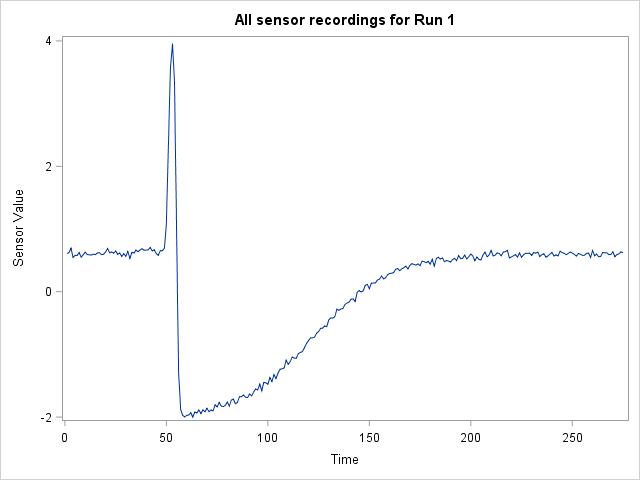
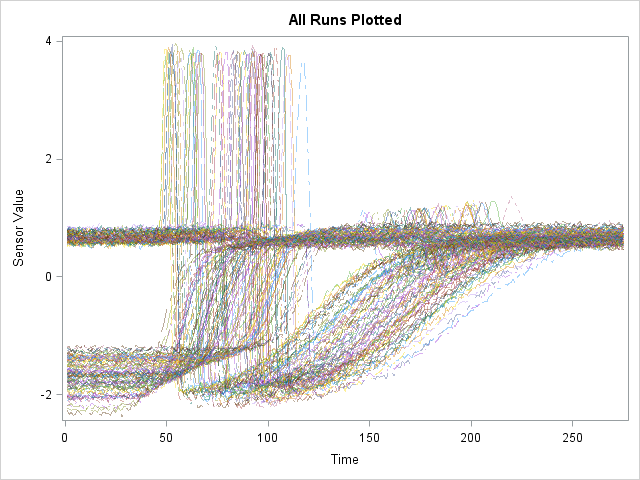

In [2]:
/*Convert to long data for graphing*/
proc transpose data=trace(drop=label) out=long(drop=_name_ rename=(COL1=sensor));
	var F: ;
	by run;
run;

/*Create time index t*/
data long;
	set long;
	by run;
	if first.run then t=0;
	t+1;
run;

title "DATA:LONG - Transposed so now each row is a second";
title2 "Sensor represents variable measure at time t";
proc print noobs data=long(obs=5);
run;
title; title2;

title "All sensor recordings for Run 1";
proc sgplot data=long (where=(run=1));
    series x=t y=sensor;
	xaxis label="Time"; yaxis label="Sensor Value";
run;
title;

title "All Runs Plotted";
proc sgplot data=long;
	series x=t y=sensor / group=run transparency=0.6;
	xaxis label="Time"; yaxis label="Sensor Value";
run;


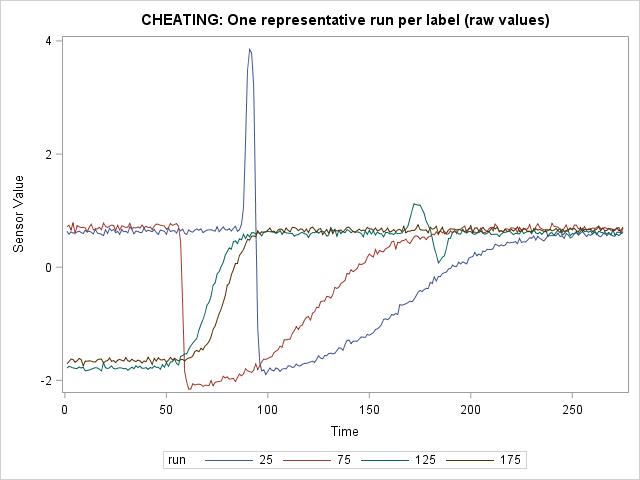

In [3]:
/*Attach true class label*/
proc sql;
	create table long as
	select *
	from long t1
	left join solution t2
	on t1.run=t2.run
	order by run, t;
quit;

title "CHEATING: One representative run per label (raw values)";
proc sgplot data=long (where=(run in (25 75 125 175)));
    series x=t y=sensor / group=run;
	xaxis label="Time"; yaxis label="Sensor Value";
run;
title;

t,run_1,run_2,run_200
1,0.43843,0.44350,0.031097
2,0.44023,0.44843,0.001562
3,0.45249,0.44417,0.018200
4,0.42774,0.43840,0.012061
5,0.43328,0.44329,0.024085
6,0.43277,0.43558,0.033313
7,0.44069,0.44353,0.018273
8,0.42826,0.43843,0.024848
9,0.43483,0.44446,0.030189
10,0.44211,0.43930,0.044175

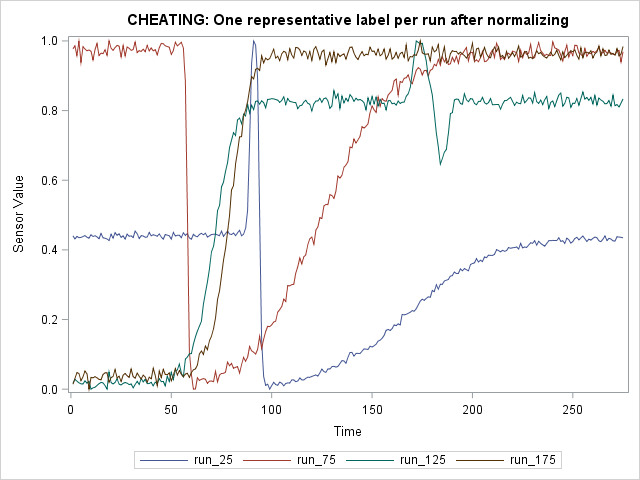

In [4]:
/*Get all runs, one column per run on common time index t*/
proc transpose data=trace out=transp(drop=_name_) prefix=run_;
	var F:;
run;

/*Create time index*/
data wide;
	length t 8.;
	set transp;
	t+1;
run;

/*Normalize all curves to between 0 and 1*/
proc stdize data=wide out=wide_std method=range;
	var run:;
run;

/*Plot normalized curves*/
title "CHEATING: One representative label per run after normalizing";
proc sgplot data=wide_std;
	series x=t y=run_25;
	series x=t y=run_75;
	series x=t y=run_125;
	series x=t y=run_175;
	xaxis label="Time"; yaxis label="Sensor Value";
run;
title;

title "DATA:WIDE_STD - Now each col is a run";
title2 "Sensor represents variable measure at time t";
proc print noobs data=wide_std(obs=10 keep=t run_1 run_2 run_200);
run;
title; title2;

In [11]:
/*Just converting wide to long for later merging with cluster membership - both for raw and std values*/

proc transpose data=wide out=long_raw;
	var run:;
	by t;
run;

proc sort data=long_raw;
	by _name_ t;
run;

data long_raw;
	set long_raw;
	rename COL1=sensor;
	run=input(substr(_name_,5),8.);
run;


proc transpose data=wide_std out=long_std;
	var run:;
	by t;
run;

proc sort data=long_std;
	by _name_ t;
run;

data long_std;
	set long_std;
	rename COL1=sensor;
	run=input(substr(_name_,5),8.);
run;

# DTW Specific Code

In [ ]:
/*Width of the Sakoe-Chiba band*/
%let warp_constraint=35;
/*Percent of max(t) to calculate warping path for*/

/*DTW Distance*/
proc similarity data=wide_std outsum=simmatrix /*plots=all*/;
   target run: / measure=sqrdev
              compress=(localpct=&warp_constraint globalpct=&warp_constraint)
              expand=(localpct=&warp_constraint globalpct=&warp_constraint);
run;

/*For more details regarding potential output diagnositcs, see: http://support.sas.com/documentation/cdl/en/etsug/63939/HTML/default/viewer.htm#etsug_similarity_sect038.htm*/

title "DTW Distance Matrix";
proc print noobs data=simmatrix(obs=5 keep=_input_ run_1--run_5);
run; title;


In [14]:
/*Cluster runs based on DTW distance*/
proc cluster data=simmatrix(drop=_status_) outtree=tree method=ward noprint;
   id _input_;
run;

/*Visualize dendogram*/
proc tree data=tree;
run;

In [18]:
%let num_clust=4; /*Split tree into this many clusters*/

proc tree data=tree ncl=&num_clust out=cluster noprint;
run;

proc sort data=cluster;
	by cluster _name_;
run;

title "Cluster Output";
proc print data=cluster(obs=10 drop=clusname);
run;

/*Merge together run values and cluster membership*/
proc sql;
	create table merge_raw as
		select *
		from long_raw t1
		left join cluster t2
		on t1._name_=t2._name_
		order by _name_, t;
quit;

proc sql;
	create table merge_std as
		select *
		from long_std t1
		left join cluster t2
		on t1._name_=t2._name_
		order by _name_, t;
quit;

Obs,_NAME_,CLUSTER
1,run_1,1
2,run_10,1
3,run_11,1
4,run_12,1
5,run_13,1
6,run_14,1
7,run_15,1
8,run_16,1
9,run_17,1
10,run_18,1



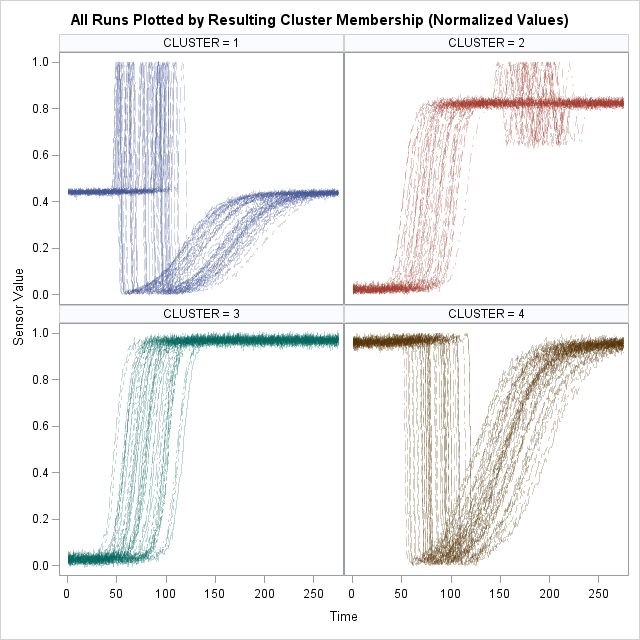
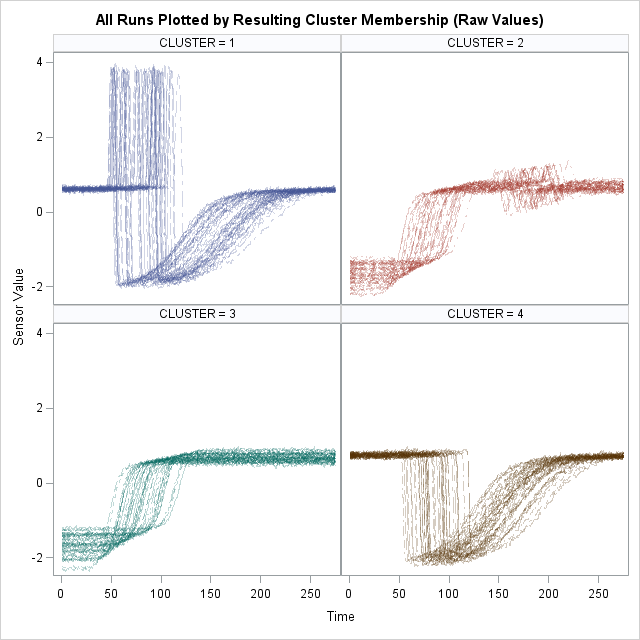

In [19]:
/*Plot results by cluster membership*/

title "All Runs Plotted by Resulting Cluster Membership (Normalized Values)";
proc sgpanel data=merge_std;
	panelby cluster;
	series x=t y=sensor / group=run transparency=0.75 grouplc=cluster;
	colaxis label="Time";
	rowaxis label="Sensor Value";
run;

title "All Runs Plotted by Resulting Cluster Membership (Raw Values)";
proc sgpanel data=merge_raw;
	panelby cluster;
	series x=t y=sensor / group=run transparency=0.75 grouplc=cluster;
	colaxis label="Time";
	rowaxis label="Sensor Value";
run;


In [23]:
/*Verify results*/
proc sql;
	create table verify_results as
	select distinct 
		t1.run, 
		t1.cluster, 
		t2.label
	from merge_raw t1
	left join solution t2
	on t1.run=t2.run
	order by run;

	create table label_by_clust as
	select distinct
		cluster,
		count(distinct label) as count_distinct_labels,
		label
	from verify_results
	group by cluster
	order by cluster;
quit;

title "Ensure each cluster is only composed of a single label value";
proc print noobs data=label_by_clust;
run;

CLUSTER,count_distinct_labels,label
1,1,1
2,1,3
3,1,4
4,1,2
